# Simple CRAG - Corrective Retrieval Augmented Generation

Inspiration: https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_crag.ipynb

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = 'sk-***'

## Setup / Grabbing Documents

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://ai-office-hours.beehiiv.com/p/beyond-benchmarks",
    "https://ai-office-hours.beehiiv.com/p/evaluating-ai-agent-tool-selection",
    "https://ai-office-hours.beehiiv.com/p/re-ranking-rag",
    "https://ai-office-hours.beehiiv.com/p/quantizing-llms-llama-3",
    "https://ai-office-hours.beehiiv.com/p/llm-probing"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512, chunk_overlap=128
)

doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="chroma-rag",
    embedding=OpenAIEmbeddings(),
    persist_directory='./db'
    
)
retriever = vectorstore.as_retriever()

In [5]:
question = "What is LLM Probing?"
docs = retriever.get_relevant_documents(question)
for doc in docs:
    print(doc.page_content[:50], '...', doc.metadata['source'])

Probing LLMs for a World ModelAI Office HoursLogin ... https://ai-office-hours.beehiiv.com/p/llm-probing
Llama or Mistral, we will grab the embedding of th ... https://ai-office-hours.beehiiv.com/p/llm-probing
An investigation into data contamination showed th ... https://ai-office-hours.beehiiv.com/p/beyond-benchmarks
using an LLM to write marketing copy or to classif ... https://ai-office-hours.beehiiv.com/p/beyond-benchmarks


In [6]:
# Only get k=3 documents

docs = vectorstore.as_retriever(search_kwargs={'k': 3}).get_relevant_documents(question)
for doc in docs:
    print(doc.page_content[:50], '...', doc.metadata['source'])

Probing LLMs for a World ModelAI Office HoursLogin ... https://ai-office-hours.beehiiv.com/p/llm-probing
Llama or Mistral, we will grab the embedding of th ... https://ai-office-hours.beehiiv.com/p/llm-probing
An investigation into data contamination showed th ... https://ai-office-hours.beehiiv.com/p/beyond-benchmarks


## Retrieval Grader

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with structured output
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)


# Prompt
system = """Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader  # llm + prompt

for doc in docs:
    doc_txt = doc.page_content
    print(retrieval_grader.invoke({"question": question, "document": doc_txt}), doc_txt[:50], '...', doc.metadata['source'])

binary_score='yes' Probing LLMs for a World ModelAI Office HoursLogin ... https://ai-office-hours.beehiiv.com/p/llm-probing
binary_score='yes' Llama or Mistral, we will grab the embedding of th ... https://ai-office-hours.beehiiv.com/p/llm-probing
binary_score='no' An investigation into data contamination showed th ... https://ai-office-hours.beehiiv.com/p/beyond-benchmarks


## Generate Compoments

In [8]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")
for message in prompt.messages:
    print(type(message))
    print(message.prompt.template)
    print('-----')

/Users/sinanozdemir/Teaching/Pearson/oreilly-ai-pipelines/.venv/lib/python3.11/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


<class 'langchain_core.prompts.chat.HumanMessagePromptTemplate'>
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
-----


In [9]:
# LLM
llm = ChatOpenAI(model_name="gpt-4.1-mini", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": format_docs(docs), "question": question})
print(generation)

LLM probing is a technique used to understand how much information is encoded within a language model's parameters by extracting and analyzing embeddings from its hidden layers. It involves applying classifiers or regression models on these embeddings to predict specific attributes, such as birth or death years of individuals mentioned in prompts. The goal is to evaluate the model's internal knowledge representation rather than its performance on a specific task.


## Question Re-writer / The Corrective Part

In [10]:
# A different LLM, just to show we can use multiple LLMs in our calls
bigger_llm = ChatOpenAI(model="gpt-4.1", temperature=0.1)

# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \n
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning.
     
Good examples of re-written queries:
Original text: "Make cookie taste better"
Re-Written text: "Techniques for enchancing flavor of cookie (chocolate chip, sugar, etc)"
"""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | bigger_llm | StrOutputParser()
question, question_rewriter.invoke({"question": question})

('What is LLM Probing?',
 'What does "LLM probing" mean in the context of large language models and artificial intelligence research?')

## Graph State

In [11]:
from typing import List

from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
        times_transformed: number of times the question has been re-written
        web_search: if we should be doing a web search (not implemented in this notebook)
    """

    question: str
    generation: str
    documents: List[str]
    times_transformed: int
    web_search: str

## The Nodes

In [12]:
from langchain.schema import Document


def set_state(state):
    """
    Sets initial state

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---SET STATE---")

    return {"times_transformed": 0}



def retrieve(state):
    print(state)
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": format_docs(documents), "question": question})
    return {"generation": generation}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    times_transformed = state["times_transformed"]
    times_transformed += 1

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    print('---NEW QUESTION---')
    print(better_question)
    return {"question": better_question, "times_transformed": times_transformed}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        print(d.metadata['source'], f'Grade: {grade}')
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
    if len(filtered_docs) == 0:
        print("---GRADE: DOCUMENTS NOT RELEVANT---")
        web_search = "Yes"
    return {"documents": filtered_docs, "web_search": web_search}


## The Edges

In [13]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]
    # state["documents"]

    if web_search == "Yes":
        # check times_transformed
        if state["times_transformed"] >= 3:
            print(
                "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION AND WE HAVE TRANSFORMED 3 TIMES, GENERATE---"
            )
            return "should_generate"

        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "should_transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "should_generate"

## Building the Graph

In [14]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("set_state", set_state)  # set_state
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "set_state")
workflow.add_edge("set_state", "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "should_transform_query": "transform_query",
        "should_generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

## Running the Graph

In [15]:
# Run
inputs = {"question": "What on earth is LLM Probing"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
# Final generation
print(value["generation"])

---SET STATE---
Node 'set_state':
{'question': 'What on earth is LLM Probing', 'generation': None, 'documents': None, 'times_transformed': 0, 'web_search': None}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
https://ai-office-hours.beehiiv.com/p/llm-probing Grade: yes
---GRADE: DOCUMENT RELEVANT---
https://ai-office-hours.beehiiv.com/p/llm-probing Grade: yes
---GRADE: DOCUMENT RELEVANT---
https://ai-office-hours.beehiiv.com/p/beyond-benchmarks Grade: no
https://ai-office-hours.beehiiv.com/p/beyond-benchmarks Grade: no
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
Node 'grade_documents':
---GENERATE---
Node 'generate':
LLM probing is a technique to analyze what information is encoded within a large language model's hidden states by extracting embeddings and using them in tasks like linear regression to predict specific attributes (e.g., birth year of a person). It helps evaluate how much factual or structured knowledge the model retains beyond just 

In [16]:
inputs = {"question": "make my LLM faster"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
# Final generation
print(value["generation"])

---SET STATE---
Node 'set_state':
{'question': 'make my LLM faster', 'generation': None, 'documents': None, 'times_transformed': 0, 'web_search': None}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
https://ai-office-hours.beehiiv.com/p/llm-probing Grade: no
https://ai-office-hours.beehiiv.com/p/beyond-benchmarks Grade: no
https://ai-office-hours.beehiiv.com/p/beyond-benchmarks Grade: no
https://ai-office-hours.beehiiv.com/p/beyond-benchmarks Grade: no
---GRADE: DOCUMENTS NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
Node 'grade_documents':
---TRANSFORM QUERY---
---NEW QUESTION---
How can I optimize the performance and speed of my large language model (LLM)?
Node 'transform_query':
{'question': 'How can I optimize the performance and speed of my large language model (LLM)?', 'generation': None, 'documents': [], 'times_transformed': 1, 'web_search': 'Yes'}
---RETRIEVE---
Node 'retriev

In [17]:
# Run
inputs = {"question": "How to make good inputs to AI?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
# Final generation
print(value["generation"])

---SET STATE---
Node 'set_state':
{'question': 'How to make good inputs to AI?', 'generation': None, 'documents': None, 'times_transformed': 0, 'web_search': None}
---RETRIEVE---
Node 'retrieve':
---CHECK DOCUMENT RELEVANCE TO QUESTION---
https://ai-office-hours.beehiiv.com/p/beyond-benchmarks Grade: no
https://ai-office-hours.beehiiv.com/p/evaluating-ai-agent-tool-selection Grade: no
https://ai-office-hours.beehiiv.com/p/quantizing-llms-llama-3 Grade: no
https://ai-office-hours.beehiiv.com/p/re-ranking-rag Grade: no
---GRADE: DOCUMENTS NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
Node 'grade_documents':
---TRANSFORM QUERY---
---NEW QUESTION---
Best practices for creating effective prompts and inputs for AI models
Node 'transform_query':
{'question': 'Best practices for creating effective prompts and inputs for AI models', 'generation': None, 'documents': [], 'times_transformed': 1, 'web_search': 'Yes'}
---RET

## Visualize the Graph

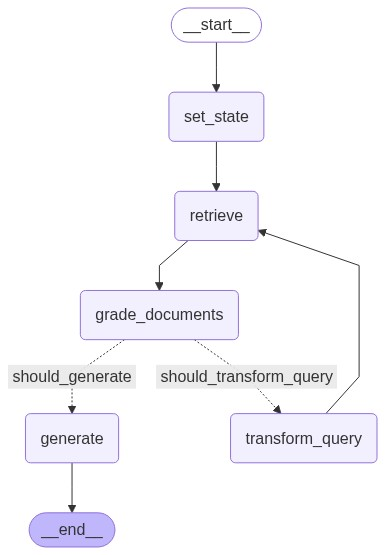

In [18]:
# Visualize our graph
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [19]:
# if the above fails try this (requires grandalf)

print(app.get_graph().draw_ascii())

ImportError: Install grandalf to draw graphs: `pip install grandalf`.